# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [9]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


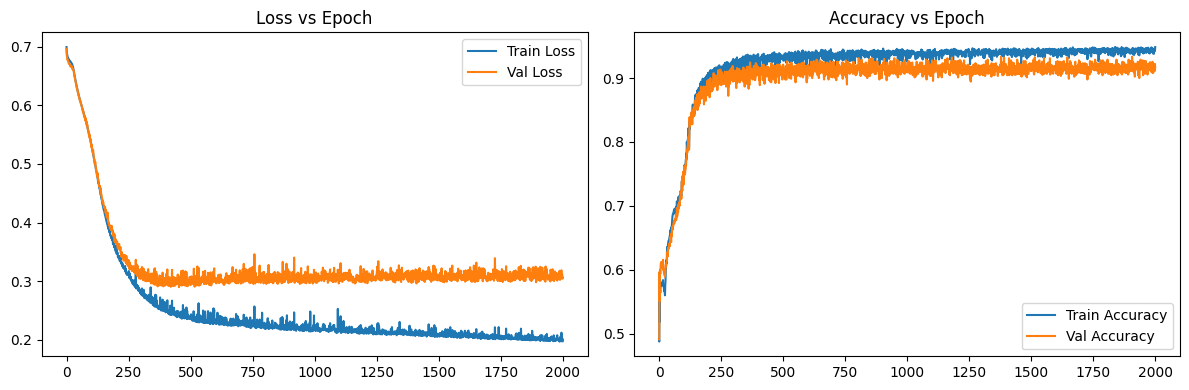

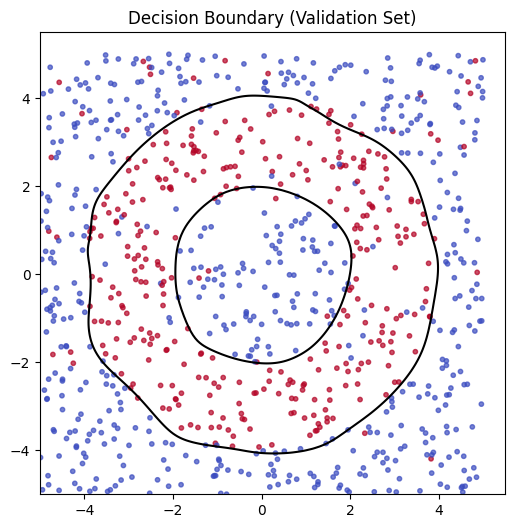

Final Train Accuracy: 0.9485714435577393
Final Val Accuracy: 0.9166666865348816


In [20]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

import torch
import matplotlib.pyplot as plt

#First Lets split samples into 70% and 30%

num_samples=X_full.shape[0]
idxs=torch.randperm(num_samples)

t_size=int(0.7*num_samples)
train_idx=idxs[:t_size]
val_idx=idxs[t_size:]

X_train=X_full[train_idx]
y_train=y_full[train_idx]

X_val=X_full[val_idx]
y_val=y_full[val_idx]

#Now definining activation functions:
def tanh(z):
    return torch.tanh(z)

def sigmoid(z):
    return 1/(1+torch.exp(-z))


#Defining parameters:
W1=(torch.randn(2,16)*0.5).requires_grad_()
b1=torch.zeros(16,requires_grad=True)

W2=(torch.randn(16,16)*0.5).requires_grad_()
b2=torch.zeros(16,requires_grad=True)

W3=(torch.randn(16,16)*0.5).requires_grad_()
b3=torch.zeros(16,requires_grad=True)

W4=(torch.randn(16,1)*0.5).requires_grad_()
b4=torch.zeros(1,requires_grad=True)


#Now making a fwd pass function:
def fwd_pass(X):
    z1=torch.matmul(X,W1)+b1
    a1=tanh(z1)

    z2=torch.matmul(a1,W2)+b2
    a2=tanh(z2)

    z3=torch.matmul(a2,W3)+b3
    a3=tanh(z3)

    z4=torch.matmul(a3,W4)+b4
    y_hat=sigmoid(z4)

    return y_hat


#Now implementing manual BCE loss:
def bce_loss(y_hat,y):
    eps=1e-7
    y_hat=torch.clamp(y_hat,eps,1-eps)
    loss=-(y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat))
    return loss.mean()


#Now defining accuracy function:
def accuracy(y_hat,y):
    preds=(y_hat>=0.5).float()
    return (preds==y).float().mean()


#Starting training:
lr=0.01
epochs=2000
batch_size=64

#NOTE USING SGD with batch size because full batch GD was not improving accuracy and stayed near 60%, which is fixed by using minibatch SGD

train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]

for epoch in range(epochs):

    perm=torch.randperm(X_train.shape[0])

    for i in range(0,X_train.shape[0],batch_size):

        idx=perm[i:i+batch_size]
        X_batch=X_train[idx]
        y_batch=y_train[idx]

        y_hat=fwd_pass(X_batch)
        loss=bce_loss(y_hat,y_batch)

        loss.backward()

        with torch.no_grad():
            W1-=lr*W1.grad
            b1-=lr*b1.grad
            W2-=lr*W2.grad
            b2-=lr*b2.grad
            W3-=lr*W3.grad
            b3-=lr*b3.grad
            W4-=lr*W4.grad
            b4-=lr*b4.grad

            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            W3.grad.zero_()
            b3.grad.zero_()
            W4.grad.zero_()
            b4.grad.zero_()

    with torch.no_grad():
        train_preds=fwd_pass(X_train)
        val_preds=fwd_pass(X_val)

        train_losses.append(bce_loss(train_preds,y_train).item())
        val_losses.append(bce_loss(val_preds,y_val).item())
        train_accs.append(accuracy(train_preds,y_train).item())
        val_accs.append(accuracy(val_preds,y_val).item())

#plotting loss and accuracy plots
epochs_range=range(epochs)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_losses,label="Train Loss")
plt.plot(epochs_range,val_losses,label="Val Loss")
plt.legend()
plt.title("Loss vs Epoch")

plt.subplot(1,2,2)
plt.plot(epochs_range,train_accs,label="Train Accuracy")
plt.plot(epochs_range,val_accs,label="Val Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")

plt.tight_layout()
plt.show()

#Plotting deceision boundary donut
x_min,x_max=-5,5
y_min,y_max=-5,5
step=0.05

xx,yy=torch.meshgrid(
    torch.arange(x_min,x_max,step),
    torch.arange(y_min,y_max,step),
    indexing='ij'
)

grid=torch.cat([xx.reshape(-1,1),yy.reshape(-1,1)],dim=1)

with torch.no_grad():
    probs=fwd_pass(grid)

Z=probs.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contour(xx,yy,Z,levels=[0.5],colors='black')

plt.scatter(
    X_val[:,0],
    X_val[:,1],
    c=y_val.squeeze(),
    cmap="coolwarm",
    s=10,
    alpha=0.7
)

plt.title("Decision Boundary (Validation Set)")
plt.show()
